# Technical Solution

## Introduction

In this section the SLAP technical solution is explained. Sail Logging Auto Pilot (SLAP) is a real time control system which uses a GPS heading as the basis for steering a sailing boat.
The steering of the boat is achieved using an actuator (servo motor) to adjust the tiller position. The skipper of the boat activates the auto pilot and the system uses an active control loop to maintain the boats heading. 

The design of the system is fully explained in the design section. This section details the implementation of this design (Technical Solution). The code for SLAP is carefully structured inline with the modular design. To aid understanding the diagram below is repeated from the Design section as it provides a helpful index to the code. The diagram has a close correspondance to the code structure. This technical solution section explains the system's architecture and each of the modules.

![figure1: Slap Architecture](systemArchitecture.drawio.png)

### Modes of Operation

SLAP has two modes of operation:

 In **Simulator Mode** the boat's dynamics (how the boat's heading changes over time in response to the tiller action) is mathmatically modelled.
 
 In **Run Mode** the tiller actuator affects the boats heading according to the actual characteristics of the boat which is reflected in the GPS readout.
 
The diagram above illustrates how the system switches between these modes. The controller, in turn, links the tiller actuator to the GPS via a PID controller system. A database is used to store the system's configuration and to act as a logger recording the detail of each trip.

## Overview
The following sections describe each module in outline, full details of their operation and coding are provided below.

### Web Browser
This is the user interface which is the web browser on the user's smartphone. The user connects to the local WiFi HotSpot on the boat, provided by the Rasberry Pi where the SLAP system is running.

### Web Server
In early the experiments the Web Server was coded using python function for HTTP handling. This was complex and required a lot of code. In the final iteration, the Web Server code is built using the Flask Python library. This allows HTTP EndPoints to be more easily coded. The Web Server includes has two primary functions. The first is to serve HTML pages and the second is to provide HTTP API EndPoints.

### Controller
This is the central coordinating module in the system. It recieves heading data in real time from the GPS, which is forwarded into the PID controller. The output of the PID then drives the tiller actuator module. The controller includes the Proportional, Integral and Differential (PID) feedback system. This PID controller attempts to adjust the boat's heading to minimise the difference between the actual heading and the target heading as set by the skipper.

### GPS
The GPS module is a real time system providing a continous update of the boats heading. The GPS module is connected to a hardware GPS board that recieves saterlite data. In 'Simulator Mode' the GPS module returns a heading provided by the boat dynamics simulator module, rather than the actual GPS. The GPS module gets data from actual GPS hardware via the sensor register.

### Tiller Actuator
This module recieves tiller angle settings from the PID controller and activates a connected servo motor to drive the tiller. In Simulator Mode this module drives the boat dynamics simulator. The tiller servo motor uses a PWM (Pulse Width Modulated) signal to set the motors position.

### Boat Dynamics Simulator
This module is used in Simulator Mode to represent the boat's behavour. It is based on the heading changing in response to the tiller action. The mathmatics of this model is based on a first order differential equation and is detailed in the Design section.

### SLAP Store
This module is an service interface which interacts with the database. The store is responsible for persisting the system configuration and for logging details of the boat's track (a set of waypoints). The SlapStore module provides an API to the other system modules to hide all database details such as database connections and SQL complexity.

### Sensor Register
The Sensor Register is a module which provides access to a list of sensors within the system. The register is filled with objects of the class Tranducer, each containing their sensors. The Sensor Register provides an API to access all sensor details within the system.

The Sensor Register and its related classes use object oriented code patterns including abstract classes and inheritance. This pattern is explained in the Design section

### Map Manager
This module is responsible for uploading Trip logs to the MapBox cloud based mapping system. It takes data from the logging module, converts it to JSON, connects to MapBox via a web interface, authenticates with the service and makes an upload

### Logger
The logger module is responsible for writing the latest system data to the database at regular intervals. It runs in its own thread and interacts with the SlapStore Service Layer to write logs to the database.

## Threading and Module Interaction
The following diagrams represent the interaction between the key modules in the system. It also illustrates which modules run in their own dedicated threads. These diagrams read alongside the system architecture diagram is key to understanding the code and its operation.

### Sensor Register

The diagram below shows how the main.py firstly creates the Sensor Register, then adds the transducers which in turn creates and their sensors. When the sensor register is run, it asks runs each Transducer in a new thread. These threads continously obtains values from the Transducers hardware and sets the values on each of its sensors. This is shown in the sequence diagram below. Not all of the objects are shown simplicity.

![slapSequenceStartUp](sensorRegisterSequence.drawio.png)

### Main Modules
The main.py contructs each of the SLAP modules. These being TillerActuator, AutoPilot, Gps, BoatSim, MapManager, Logger and SlapStore.
These modules are then wired together as seen in the System Architecture diagram. The main finally creats and starts the Web Server in a seperate thread.

## Code Packages

The following sections detail the package of code which form the each modules including their operation and the code itself.

### File Structure:

The following file structure is organised inline with the modules described above.

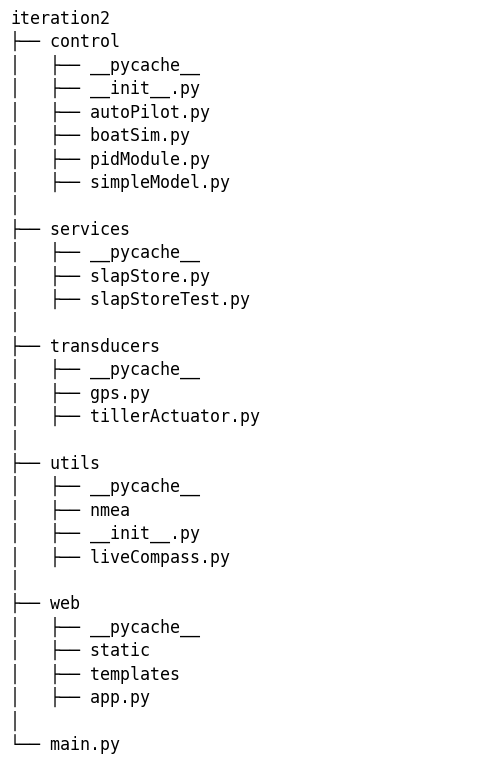

### Main.py

This code is the entry point for the program's execution. It starts by instantiating each of the main classes in the system in turn. When a class is created the necessary dependancies are passed in. These dependancies are the solid arrows shown in the system diagram (figure 1). Instantiating the main classes and passing them into the other classes ensures only a single instance of each is created.

Being a real time system SLAP has a number of program threads running simultanously as explained above. main.py as shown below is responsible for starting the various execution threads within the system. These are the Web Server and the GPS.



In [ ]:
# %load slap/src/iteration2/main.py
#                               Project Entry Point                              # 
from services.mapManager import MapManager
from services.slapStore import SlapStore
from control.autoPilot import AutoPilot
from control.boatSim import BoatSim
from web.app import WebServer
from transducers.gps import Gps
from transducers.tillerActuator import TillerActuator
from services.logger import Logger
import threading
import time
import atexit
from transducers.sensorRegister import SensorRegister
from transducers.bmp280Transducer import Bmp280Transducer
from transducers.neo6mGps import Neo6mGps
from transducers.icm20948Magnetometer import ICM20948Magnetometer

class Main():

    def __init__(self):

        # Produce an instance of the sensor register and add transducers to it
        self.sensor_register = SensorRegister()
        bmp280 = Bmp280Transducer()
        gps = Neo6mGps()
        magnetometer = ICM20948Magnetometer()
        self.sensor_register.add_transducer(bmp280)
        self.sensor_register.add_transducer(gps)
        self.sensor_register.add_transducer(magnetometer)
        # Start the transducers in separate threads
        self.sensor_register.run_transducers()
        
        # Init an instance of the SLAP modules
        self.tiller_actuator = TillerActuator()
        self.auto_pilot = AutoPilot()
        self.gps = Gps()
        self.boat_sim = BoatSim(self.sensor_register, self.gps)
        self.map_manager = MapManager()
        self.logger = Logger(self.gps, self.map_manager, self.sensor_register)
        self.store = SlapStore("slap.db")

        # Link classes together
        # Ensuring only one common instance of each module is used
        self.gps.setAutoPilot(self.auto_pilot)
        self.auto_pilot.setTillerActuator(self.tiller_actuator)
        self.tiller_actuator.setBoatSim(self.boat_sim)
        self.logger.setStore(self.store)


    def main(self):
        
        # Start the boat in real mode in a new thread
        self.boat_sim.stopSim()
        
        # Add each sensor to the database
        for sensor in self.sensor_register.getSensors():
            self.store.addSensor(sensor)

        # Ensure the controller stops when the application exits
        atexit.register(self.boat_sim.stopSim)

        # Create Flask web server
        webserver = WebServer(self.auto_pilot, self.logger, self.sensor_register, self.boat_sim, self.gps) 
        app = webserver.create_server(self.store)

        # Start the web server in a new thread
        app.run(debug=True, use_reloader=False, port=5000, host='0.0.0.0')


# This is where the application starts executing
if __name__ == '__main__':
    main = Main()
    main.main()
    


## Transducers, Sensors and the Sensor Register

### Sensor Register
The Sensor Register as explained above holds a list of the Transducers, each with their respective Sensors. The register is responsible for starting all the Transducer threads.

In [ ]:
# %load slap/src/iteration2/transducers/sensorRegister.py
from transducers.transducer import Transducer

class SensorRegister:
    def __init__(self):
        self.transducers = []

    #Defines service methods for the sensor register

    def add_transducer(self, transducer: Transducer):
        self.transducers.append(transducer)
        
    def get_transducers(self):
        return self.transducers
    
    #Starts Trandsucers in separate threads
    def run_transducers(self):
        for transducer in self.transducers:
            transducer.start()
            
    #Stops transducer Threads
    def stop_transducers(self):
        for transducer in self.transducers:
            transducer.stop()

    def getSensorReadings(self):
        sensors = []
        for transducer in self.transducers:
            for sensor in transducer.getSensors():
                output = {
                    "identifier": sensor.getIdentifier(),
                    "name": sensor.getName(),
                    "value": sensor.getData(),
                    "units": sensor.getUnits()
                }
                sensors.append(output)
        return sensors
    
    def getSensor(self, name):
        for transducer in self.transducers:
            for sensor in transducer.getSensors():
                if sensor.getName() == name:
                    return sensor
        raise Exception("No sensor found with name: " + name)

    def getSensors(self):
        sensors = []
        for transducer in self.transducers:
            for sensor in transducer.getSensors():
                sensors.append(sensor)
        return sensors


#### Transducers

This package contains the Transducer code. There are three Transducers, the bmp280, ICM20948, and the NOE6M GPS. 

The Transducer classes create the Sensors in each hardware module, and contain the code to interface the hardware with the Raspberry Pi.

The interfacing hardware code for each module was obtained for internet examples.

**bmp280 Transducer**

The bmp280 contains a temperature and pressure sensor.

In [ ]:
# %load slap/src/iteration2/transducers/bmp280Transducer.py
try:
    from smbus2 import SMBus
    from bmp280 import BMP280
    IS_RPI = True
    print("Running on a Raspberry Pi")
except (ImportError, ModuleNotFoundError, RuntimeError):
    print("Not running on a Raspberry Pi")
    IS_RPI = False

from transducers.transducer import Transducer
import time
import threading
from transducers.sensor import Sensor

class Bmp280Transducer(Transducer):
    def __init__(self):
        super().__init__()  # This calls the parent class's __init__

        # Create the Sensors provided by this hardware
        self.temperature = Sensor(self, "temperature", "Temperature", "°C")
        self.pressure = Sensor(self, "pressure", "Pressure", "hPa")
        self.sensors = [self.temperature, self.pressure]
        self.running = False
        # Checks if code is running on a Raspberry Pi
        # If so, initializes the BMP280 hardware
        if IS_RPI:
            self.bus = SMBus(1)
            self.bmp280 = BMP280(i2c_dev=self.bus)


    def run(self):
        # Main thread loop that continuously reads pressure
        while self.running:
            try:
                if IS_RPI:
                    self.pressure.setData(str(self.bmp280.get_pressure()))
                    self.temperature.setData(str(self.bmp280.get_temperature()))
                else:
                    self.pressure.setData("1013.25")  # Standard atmospheric pressure in hPa
                    self.temperature.setData("20")
                #print(f"{self.name}, Value: {self.getData()}")
                time.sleep(0.1)  # Read pressure every 100ms
            except:
                print("Error reading pressure sensor")
                time.sleep(1)  # Wait longer on error


**icm20948 Transducer**

The icm20948 provides a three axis magnetometer and a three axis accelerometer. In SLAP we currently only utilise the magnetometer to calculate a heading

In [ ]:
# %load slap/src/iteration2/transducers/icm20948Magnetometer.py
import math
import time
from transducers.transducer import Transducer
from transducers.sensor import Sensor
try:
    from icm20948 import ICM20948
    IS_RPI = True
except Exception as e:
    print(f"Error loading magnetometer: {e}")
    IS_RPI = False



class ICM20948Magnetometer(Transducer):
    def __init__(self):
        super().__init__()
        self.heading = Sensor(self, "magheading", "MagHeading", "°")
        self.sensors = [self.heading]
        self.running = False
        
        if IS_RPI:
            self.imu = ICM20948()

    def run(self):
        if IS_RPI:
            X = 0
            Y = 1
            Z = 2
            AXES = Y, Z
            amin = list(self.imu.read_magnetometer_data())
            amax = list(self.imu.read_magnetometer_data())
        
        while self.running:
            if IS_RPI:
                # Read the current, uncalibrated, X, Y & Z magnetic values from the magnetometer and save as a list
                mag = list(self.imu.read_magnetometer_data())

                # Step through each uncalibrated X, Y & Z magnetic value and calibrate them the best we can
                for i in range(3):
                    v = mag[i]
                    # If our current reading (mag) is less than our stored minimum reading (amin), then save a new minimum reading
                    # ie save a new lowest possible value for our calibration of this axis
                    if v < amin[i]:
                        amin[i] = v
                    # If our current reading (mag) is greater than our stored maximum reading (amax), then save a new maximum reading
                    # ie save a new highest possible value for our calibration of this axis
                    if v > amax[i]:
                        amax[i] = v

                    # Calibrate value by removing any offset when compared to the lowest reading seen for this axes
                    mag[i] -= amin[i]

                    # Scale value based on the highest range of values seen for this axes
                    # Creates a calibrated value between 0 and 1 representing magnetic value
                    try:
                        mag[i] /= amax[i] - amin[i]
                    except ZeroDivisionError:
                        pass
                    # Shift magnetic values to between -0.5 and 0.5 to enable the trig to work
                    mag[i] -= 0.5

                # Convert from Gauss values in the appropriate 2 axis to a heading in Radians using trig
                # Note this does not compensate for tilt
                heading = math.atan2(
                        mag[AXES[0]],
                        mag[AXES[1]])

                # If heading is negative, convert to positive, 2 x pi is a full circle in Radians
                if heading < 0:
                    heading += 2 * math.pi

                # Convert heading from Radians to Degrees
                heading = math.degrees(heading)
                # Round heading to nearest full degree
                self.heading.setData(heading)
                print("mag Heading: ", heading)

                time.sleep(0.1)
            else:
                self.heading.setData(0)
                time.sleep(1)


**Neo6M GPS Transducer**

This Transducer is a GPS reciever. It connects to GPS satelites and provides a range of information. In SLAP we only create sensors for heading, the longitude and latitude position.

In [ ]:
# %load slap/src/iteration2/transducers/neo6mGps.py
from transducers.transducer import Transducer
from transducers.sensor import Sensor
import math
try:
    import serial
    import time
    import string
    import pynmea2
    IS_RPI = True
except Exception as e:
    print(e)
    IS_RPI = False  


# This class is a transducer for the NEO-6M GPS module.
# It inherits from the Transducer class and provides methods to read GPS data.
# The class has two sensors: one for heading and one for position.
# It uses the pynmea2 library to decode NMEA 0183 protocol sentences.
class Neo6mGps(Transducer):
    def __init__(self):
        super().__init__()  # This calls the parent class's __init__
        self.heading = Sensor(self, "gpsHeading", "Heading", "°")
        self.position = Sensor(self, "gpsPosition", "Position", "lon, lat")
        self.sensors = [self.heading, self.position]
        self.running = False
        self.lng = 50
        self.lat = -3
        if IS_RPI:
            self.port = "/dev/ttyAMA0"
            self.ser = serial.Serial(self.port, baudrate=9600, timeout=0.5)

    def getLongitude(self):
        return self.lng 
    
    def getLatitude(self):
        return self.lat
    
    def run(self):
        while self.running:
            try:
                # Check if the code is running on a Raspberry Pi
                # If so, read data from the GPS module
                if IS_RPI:
                    #print("Running NEO6M")
                    newdata = self.ser.readline()
                    newdata = newdata.decode('utf-8')

                    # Returns longitude and latitude in decimal degrees
                    if "GLL" in newdata:
                        newmsg=pynmea2.parse(newdata)
                        self.lat=newmsg.latitude
                        self.lng=newmsg.longitude
                        pos = f"{self.lng},{self.lat}"
                        self.position.setData(pos)
                        
                    # Returns heading in degrees
                    if "HCHDG" in newdata:
                        newmsg=pynmea2.parse(newdata)
                        heading=newmsg.heading
                        self.heading.setData(heading)
                        
                else:
                    self.position.setData("50.604531, -3.408637")
                    self.heading.setData("0")
            except:
                print("Error reading GPS data")


## Main Modules
The following sections show the main modules shown in the architecture diagram

### GPS Module
The GPS module provides heading and positional data to the rest of the system. In Real Mode the GPS module is supplied by the position and heading data from the appropiate sensors in the sensor register. In Sim Mode the Boat Simulator will pass in the simulated position and heading data to the GPS module.

In [ ]:
# %load slap/src/iteration2/transducers/gps.py
from utils.nmea.nmeaEncoder import Encoder
from control.autoPilot import AutoPilot
class Gps:
    def __init__(self):
        # Import the instance of the auto pilot

        self.longitude = "0.0"
        self.latitude = "0.0"
        self.heading = 0.0
        self.encoder = Encoder()

    def update(self, heading, longitude, latitude, time):
        #print("heading in gps.py is: ", heading)
        self.auto_pilot.update(heading, time)
        self.longitude = longitude
        self.latitude = latitude
        self.heading = heading

    def setAutoPilot(self, auto_pilot: AutoPilot):
        self.auto_pilot = auto_pilot

    def getPos(self):
        pos = {'lon': self.longitude,
               'lat': self.latitude}
        return pos
        
    def getHeading(self):
        return self.heading

### Boat Simulator Module
boatSim.py implements the boat dynamics algorithm which models the boat's heading which responds to changes in the boat's tiller position. This is a threaded module, meaning the boat's position and heading are continously updated. The Boat Simulator algorithm calculates the heading. A Geo Positional library is used to calculate the longitude and latitude for the boat's position based on the boat's current position and simulated speed.

The boats simulator also incudes modeling for boat heading disturbances. The details of this algorithm are in the Design section


In [ ]:
# %load slap/src/iteration2/control/boatSim.py
from geopy.distance import geodesic
from geopy.point import Point
from transducers.sensorRegister import SensorRegister
import sys
import os
from threading import Thread
import time
import math
import random

# Used for the decay equation
TIMECONSTANT = 0.333333
MAX_DISTURBANCE_DURATION = 5000 # ms
MIN_DISTURBANCE_DURATION = 2000 # ms
MAX_DISTURBANCE_MAGNITUDE = 20 # degrees per second
class BoatSim:

    def __init__(self, sensor_register: SensorRegister, gps):
        # Imports the heading variable
        self.gps = gps
        self.heading = 0.0 # Degrees
        self.running = False
        self.speed_over_ground = 50 #knots
        self.pos = Point(50.604531, -3.408637)
        self.sensor_register = sensor_register
        self.simThread = Thread(target=self.simulatedLoop, daemon=True)
        self.readSensorThread = Thread(target=self.readSensorLoop, daemon=True)
        

    def startSim(self):
        # Starts the control system on a new thread
        self.running = True
        if self.readSensorThread.is_alive():
            self.readSensorThread.join()
        self.simThread = Thread(target=self.simulatedLoop, daemon=True)    
        self.simThread.start()
        self.rudderAngle = 0
        
    def stopSim(self):
        # Stops the system
        self.running = False
        if self.simThread.is_alive():
            self.simThread.join()

        # Create a new thread instance for reading sensors
        self.readSensorThread = Thread(target=self.readSensorLoop, daemon=True)
        self.readSensorThread.start()
        self.rudderAngle = 0

    def simulatedLoop(self):
        while self.running: 
            # Gets current time and creates a disturbance
            self.currentTimeMilli = int(round(time.time() * 1000))
            self.nextDisturbance = self.createDisturbance()
            self.previousTime = 0
            while self.running:

                # Preforms one iteration of the boats movements and ensures its a usable value
                self.currentTimeMilli = int(round(time.time() * 1000))

                if self.previousTime != 0:
                    dt = (self.currentTimeMilli - self.previousTime) / 10**3
                else:
                    dt = 0

                # Calculate new long/lat based on distance travelled and current heading
                newPos = self.getNewPosition(self.pos, self.speed_over_ground, self.heading, dt)
                disturbance = self.disturbance()
                
                # Calculates new yaw rate based on rudder angle and disturbance
                yawRate = (1 / TIMECONSTANT) * self.rudderAngle + disturbance
                # ψ(t) = ψ(0) + δ * [t/T + (exp(-t/T) - 1)]
            
                # Calculates new heading based on yaw rate and time since last update
                newHead = (self.heading + yawRate * (dt / TIMECONSTANT + (math.exp(-dt / TIMECONSTANT) - 1))) % 360
                
                # Updates the GPS with the new heading and position
                self.gps.update(newHead, str(newPos.longitude), str(newPos.latitude), self.currentTimeMilli)
                self.heading = newHead
                self.pos = newPos
                self.previousTime = self.currentTimeMilli
    
    
    def readSensorLoop(self):
        # This is our Run Mode Loop
        # Starts reading the sensors and passing the data to the GPS
        while not self.running:
            self.currentTimeMilli = int(round(time.time() * 1000))
            heading = self.sensor_register.getSensor("MagHeading").getData()
            position = self.sensor_register.getSensor("Position")
            posModule = position.getTransducer()
            longitude = posModule.getLongitude()
            latitude = posModule.getLatitude()
            self.gps.update(heading, longitude, latitude, self.currentTimeMilli)

    def disturbance(self):
        currentTimeMilli = int(round(time.time() * 1000))

        # Checks if disturbance is active and returns the disturbance value
        # If not, creates a new disturbance
        if (currentTimeMilli < self.nextDisturbance['startTime']):
            print("time until disturbance",self.nextDisturbance['startTime'] - currentTimeMilli)
            return 0
        elif currentTimeMilli > self.nextDisturbance['startTime'] and currentTimeMilli < self.nextDisturbance['endTime']:
            print("During")
            print("time left: " , (self.nextDisturbance['endTime'] - currentTimeMilli))
            return self.nextDisturbance['disturbance']
        else:
            print("After")
            self.nextDisturbance = self.createDisturbance()
            return 0
    
    
    def setRudderAngle(self,angle):
        self.previousTime = self.currentTimeMilli
        self.rudderAngle = angle

    def createDisturbance(self):
        # Creates a disturbance with a random magnitude and duration
        # The disturbance is a random value between -MAX_DISTURBANCE_MAGNITUDE and MAX_DISTURBANCE_MAGNITUDE
        currentTimeMilli = int(round(time.time() * 1000))
        disturbance =  random.randint(-MAX_DISTURBANCE_MAGNITUDE, MAX_DISTURBANCE_MAGNITUDE)
        startTime = currentTimeMilli + random.randint( MAX_DISTURBANCE_DURATION, 2 * MAX_DISTURBANCE_DURATION)
        endTime = startTime + random.randint(MIN_DISTURBANCE_DURATION,MAX_DISTURBANCE_DURATION)
        output = {'endTime': endTime,
                'disturbance': disturbance,
                'startTime': startTime}
        print(output)
        return output
    

    def getNewPosition(self, start_position: Point, speed_kt, heading_deg, time_secs):
        # Calculate the distance travelled in km based on speed and time
        distance_km = (speed_kt * 1.852) * (time_secs / (60 * 60))  # Convert knots to km/h and compute distance
        #print(distance_km)
        return geodesic(kilometers=distance_km).destination(start_position, heading_deg)

### Tiller Actuator Module
The Tiller Actuator is used to turn the variables in the system into usable motor control signals for the servo motor to the physically turn the rudder. However in Sim Mode tillerActuator.py sets the angle of the simulated rudder, which in turn affects the heading of the boat simulation code.

This module contains the code to interface the RPi5 with a servo motor. This is achieved using the hardware PWM function in the RPi5. This proved necessary since when implemented using a software PWM the other threads in the system causes the PWM timing to jitter.


**Servo Motor Implementation**

The tiller is driven by a servo motor. In this prototype project a small servo motor. The motor used is a 20kg 8120MG 270 degree servo. The motor operates over its full range of 0 to 270 degrees in response to a pulse width modulated (PWM) signal, where the pulse widths range from 0.5ms to 2.5ms. Therefore the midpoint is where the pulse width is 1.5ms. The frequency of the signal according to the motor specification is 50hz and therefore a 20ms period is used. The diagram below illustrates the required PWM signals.

The motors PWM pattern:

![servo](servo.drawio.png)

The following code implements the hardware interface and PWM functions as described.

In [ ]:
# %load slap/src/iteration2/transducers/tillerActuator.py
from control.boatSim import BoatSim
import time
try:
    from rpi_hardware_pwm import HardwarePWM
    IS_RPI = True
    print("Running motor from Pi")
except (ImportError, ModuleNotFoundError, RuntimeError):
    print("Not running on a Raspberry Pi")
    IS_RPI = False


# Constants for the servo motor
RUDDER_COEFFICIENT = 25
SERVO_RANGE = 270

class TillerActuator():
    
    def __init__(self):
        # Create the PWM object for the servo motor
        # This is only used when running on a Raspberry Pi
        if IS_RPI:
            # Set up the PWM channel for the servo motor
            self.p = HardwarePWM(pwm_channel=2, hz=50,chip=2)
            self.p.start(100)
            self.cycle = 0
        else:
            self.cycle = 0
 
    def setBoatSim(self, boat_sim: BoatSim):
        self.boat_sim = boat_sim

    def setTurnMag(self, turn_mag):
        # Set the turn magnitude for the boat simulation if in Sim Mode
        angle = RUDDER_COEFFICIENT * turn_mag
        self.boat_sim.setRudderAngle(angle)
        if IS_RPI:
            # Sets the servo angle based on the turn magnitude
            self.setServo(turn_mag)
        return angle
    
    def setServo(self, turn_mag: float):
        # The PWM signals function between a range of 0.5ms to 2.5ms
        # The centre point therefore being 1.5ms
        milli = 1.5 + float(turn_mag)
        self.cycle = (milli / 20) * 100
        print("Cycle is: ", self.cycle)
        self.p.change_duty_cycle(self.cycle)

        


### Auto Pilot Module

autoPilot.py is the main boat controller. It reads the GPS to find out the current heading and the target heading which are fed to the PID algorithm. The PID algorithm uses the PID constants and the equation to calculate a new Tiller Actuator position. This is fed to the actuator to control the rudder angle. It also contains start / stop functions to start the system or stop it. It contains set and get functions for the headings.

In [ ]:
# %load slap/src/iteration2/control/autoPilot.py
import control.pidModule
from services.slapStore import SlapStore, Config
from control.pidModule import PidController
from transducers.tillerActuator import TillerActuator
from threading import Thread
from utils.nmea.nmeaDecoder import Decoder
from utils.headings import angularDiff
import time
import math
import random


# If the difference between the target and actual heading is greater that
# the limit of control then fully extend the tiller
LIMIT_OF_CONTROL = 30 

class AutoPilot():

    def __init__(self):
        # Imports all the needed instances for the controller
        # Creates all needed variable for the controller
        self.thread = None
        self.data_store = SlapStore("slap.db")
        self.proportional = 0
        self.integral = 0
        self.differential = 0 
        self.pid_controller = PidController( self.proportional, self.integral, self.differential, LIMIT_OF_CONTROL)

        self.target_heading = 0
        self.decoder = Decoder()
        self.actual_heading = 0.0
        self.tiller_angle = 0.0
        self.config = None
        self.running = False
        
    def start(self):
        self.pid_controller.reset()
        self.running = True

    def stop(self):
        self.running = False

    def setHeading(self,input):
        # set Heading to the input
        self.target_heading = input
        return self.target_heading
    
    def getPilotValues(self):
        # Returns a dictionary of both heading values
        headings = {
            'target': self.target_heading,
            'tiller': self.tiller_angle
        }
        return headings
    
    def setTillerActuator(self,tiller_actuator):
        self.tiller_actuator = tiller_actuator

    def update(self, heading, time):
        # Preforms one iteration of the control
        if self.running:
            self.actual_heading = heading
            # Preforms one iteration of the PID controller
            diff = angularDiff(self.actual_heading, self.target_heading)

            if abs(diff) <= LIMIT_OF_CONTROL:
                turn_mag = self.pid_controller.pid(self.actual_heading, self.target_heading, time)
            else:
                # If we go outside the control range we must reset the PID controller
                self.pid_controller.reset()        
                if diff > 0:
                    turn_mag = 1
                elif diff < 0:
                    turn_mag = -1

            # Sets the new rudder angle to the output
            self.tiller_angle = self.tiller_actuator.setTurnMag(turn_mag)
        else:
            self.tiller_angle = 0
    

    # This function is used to calculate the error between the target and actual heading
    # It takes into account the wrap around at 360 degrees
    def getHeadingError(self, target, heading):
        if target - heading <= 180:
            error = target - heading
        else:
            error = (target - heading) - 360
        return error
    
    def setPidValues(self, config: Config):
        self.config = config
        self.pid_controller.setGains(config)
    
    def getCurrentConfig(self):
        return self.config


### PID Module
pidModule.py is the PID control algorithm with takes the current heading, target heading and the gains for each aspect of the calculation (proportional, integral and differential).
The PID module works by taking the error (distance between the target heading and current heading).

Adding that to the integral of the error so as the current heading sits apart from the target heading the area under the error-time graph will increase, therefore the output to increase. 

This is then added to the differential, where the differential of the error is taken, also known as the rate of change of heading, this being the gradient of the heading-time graph. The use of differential allows us to measure the speed that we are heading towards the target heading, meaning we can dampen the speed as we get nearer the target.

The sum of all these values gives us the function to take the current and target heading and get an output which can adjust the rudder to get us closer to the target heading.

In [ ]:
# %load slap/src/iteration2/control/pidModule.py
from utils.headings import angularDiff
from services.slapStore import Config
class PidController:

    def __init__(self,KP,KI,KD, LIMIT_OF_CONTROL):
        # Imports the gains to be used
        self.kp = KP
        self.ki = KI
        self.kd = KD
        self.accumlatedError = 0
        self.lastPos = 0
        self.elapsed = 0
        self.time = 0
        self.previous_time = 0
        self.LIMIT_OF_CONTROL = LIMIT_OF_CONTROL


    def pid(self, pos: int, target: int, time: int):
        self.time = time
        intergal = 0
        differential = 0

        # PROPORTIONAL-------
        error = angularDiff(pos, target)
        proportional = error

        if self.previous_time != 0:
            dt = (self.time - self.previous_time) / 10**3
        else:
            dt = 0

        
        if dt != 0.0:
            # If this is the first run through we cannout calculate dt, so we don't find D or I

           
            # Intergral----------
            intergal = ((error * dt) + self.accumlatedError)
            self.accumlatedError = intergal


            # Differential-------
            if self.lastPos != None:

                dpos = self.lastPos - pos
                differential = (dpos / dt)
                # Stores the previous position
                # to use in the differential equation next time it is run
            else:
                differential = 0
            self.lastPos = pos

        self.previous_time = self.time
    
        # Returns the addition of all these values adjusted using the gains
        return (self.kp * proportional + self.ki * intergal + self.kd * differential) / self.LIMIT_OF_CONTROL
    
    def reset(self):
        # Resets the PID controller to its default values
        self.accumlatedError = 0
        self.elapsed = 0
        self.lastPos = None
        self.previous_time = 0

    def setGains(self, config: Config):
        print("setting gains")
        self.kp = config.proportional
        self.ki = config.integral
        self.kd = config.differential
        self.reset()


### Web Server Module

This package contains the components that run the web server and allow it to interact with the rest of the system:
This module contains all the HTML files to be served to the client, the javascript and all images used.

The web server (app.py) has two main functions:

1. Serving HTML files: These HTML files are the user interfaces which are presented on the user's smartphone.

     - The Main Navigation page (/)
 
     - The List Configs page (/configs)
     
        - Edit Config page (/configs/<configId>)
 
     - The List Trips page (/trips)
 
        - View Trip page (/trips/<tripId>)
 
     - The List Sensors page (/sensors)

2. Providing HTTP methods: These are the API calls used by the browser to interact with the system they are:
  
     - Starting the pilot (/api/startPilot)

     - Stopping the pilot (/api/stopPilot)

     - Uploading trip data to Mapbox (/api/uploadTrip/<tripId>)

     - Getting current heading (/api/heading)

     - Setting target heading (/api/setHeading)

     - Getting sensor readings (/api/readings)

     - Getting list of configurations (/api/configs)

     - Getting list of trips (/api/trips)

     - Getting specific trip details (/api/trip/<tripId>)

     - Getting list of sensors (/api/sensors)

     - Getting specific sensor details (/api/sensor/<sensorId>)

     - Starting trip logging (/api/startLogging)

     - Stopping trip logging (/api/stopLogging)

In [2]:
# %load slap/src/iteration2/web/app.py
import os
from flask import Flask, request, render_template, jsonify, g, redirect, url_for
from flask.wrappers import Response
from services.slapStore import SlapStore, Config, Trip
from control.autoPilot import AutoPilot
from utils.headings import compassify
from services.logger import Logger
from transducers.sensorRegister import SensorRegister
from control.boatSim import BoatSim
from transducers.gps import Gps
import threading
import queue
import time
import json
from datetime import datetime

class WebServer:
    # Initialises the web server with required components
    def __init__(self, auto_pilot: AutoPilot, logger: Logger, sensor_register: SensorRegister, boat_sim: BoatSim, gps: Gps):
        # Importing the Auto Pilot instance
        self.auto_pilot = auto_pilot
        self.logger = logger
        self.sensor_register = sensor_register
        self.logging = False
        self.current_trip = None
        self.boat_sim = boat_sim
        self.gps = gps

    # Creates and configures the Flask web server
    def create_server(self, store: SlapStore):
        # Creating instances of Flask and the Database service
        app = Flask(__name__)
        self.store = store
        # Load boat data

        # Loads all configurations from the store
        def load_configs():
            f = store.listConfigs()
            print({'configs': f})
            return {'configs': f}

        # Loads all trips from the store
        def load_trips():
            trips = store.listTrips()
            print({'trips': trips})
            return {'trips': trips}

        # Template Routes
        
        # Renders the home page
        @app.route("/")
        def home():
            # Default Route
            return render_template('index.html')

        # Displays sensor readings on a dedicated page
        @app.route('/sensorsReadings')
        def sensorsReadings():
            data = self.sensor_register.getSensorReadings()
            print(data)
            return render_template('sensorsDisplay.html', sensorReadings = data)

        # Shows all configurations
        @app.route('/configs')
        def index():
            data = load_configs()
            return render_template('configs.html', configs = data["configs"])

        # Shows all trips
        @app.route('/trips')
        def trips():
            data = load_trips()
            return render_template('trips.html', trips=data["trips"])

        # Displays details of a specific trip
        @app.route('/view_trip/<int:tripId>', methods=['GET'])
        def view_trip(tripId):
            # Get trip details
            trip = self.store.getTrip(tripId)
            if not trip:
                return redirect(url_for('trips'))
            return render_template('view_trip.html', trip=trip)

        # Handles editing of configurations
        @app.route('/edit/<int:configId>', methods=['GET'])
        def edit(configId):
            if configId == 0:
                config = {'configId': 0, 'name': 'New Config', 'proportional': '0', 'integral': '0', 'differential': '0'}
                return render_template('edit.html', config=config)
            else:
                data = load_configs()
                config = next((proportional for proportional in data['configs'] if proportional['configId'] == configId), None)
                if config:
                    return render_template('edit.html', config=config)
                return redirect(url_for('index'))

        # Saves configuration changes
        @app.route('/save', methods=['POST'])
        def save():
            config_configId = int(request.form['configId'])
            print(config_configId)
            if config_configId == 0:
                config = Config(0, str(request.form['name']),float(request.form['proportional']),float(request.form['integral']),float(request.form['differential']))
                self.store.newConfig(config)
            else:
                updated_config = {
                    'configId': config_configId,
                    'name': request.form['name'],
                    'proportional': request.form['proportional'],
                    'integral': request.form['integral'],
                    'differential': request.form['differential']
                }
                updated_config = Config(updated_config['configId'], updated_config['name'], updated_config['proportional'], updated_config['integral'], updated_config['differential'])
                self.store.updateConfig(updated_config)
            return redirect(url_for('index'))

        # Selects a configuration as active
        @app.route('/select/<int:configId>', methods=['POST'])
        def select(configId):
            config = self.store.getConfig(configId)
            self.auto_pilot.setPidValues(config)
            self.store.setDefault(configId)
            return jsonify({'message': f'Selected config with ID: {configId}'})

        # Deletes a configuration
        @app.route('/delete/<int:configId>', methods=['POST'])
        def deleteConfig(configId):
            self.store.deleteConfig(configId)
            return redirect(url_for('index'))

        # API Routes
        
        # Sets the target heading for the autopilot
        @app.route('/api/setDirection', methods=['PUT'])
        def setDirection():
            try:
                heading = request.get_data().decode('utf-8')
                if int(heading) < 0 or int(heading) > 360:
                    response_data = {"angle": "Enter a value between 0 and 360"}
                    return jsonify(response_data), 200
                heading = self.auto_pilot.setHeading(int(heading))
                response_data = {"angle": str(heading)}
                return jsonify(response_data), 200
            except Exception as e:
                print(f"Error processing setDirection request: {str(e)}")
                return jsonify({"error": str(e)}), 400
            
        # Returns current heading information
        @app.route('/api/headings', methods=['GET'])
        def get_headings():
            heading = self.gps.getHeading()
            pilot_values = self.auto_pilot.getPilotValues()
            headings = {
                'target': pilot_values['target'],
                'tiller': pilot_values['tiller'],
                'actual': heading
            }
            return jsonify(headings)

        # Adjusts the current heading by a specified amount
        @app.route('/api/addDirection', methods=['PUT'])
        def addDirection():
            try:
                change = request.get_data().decode('utf-8')
                headings = self.auto_pilot.getPilotValues()
                heading = headings['target']
                heading = heading + int(change)
                heading = compassify(heading)
                heading = self.auto_pilot.setHeading(heading)
                response_data = {"angle": str(heading)}
                return jsonify(response_data), 200
            except Exception as e:
                print(f"Error processing request: {str(e)}")
                return jsonify({"error": str(e)}), 400
        
        # Toggles the logging system
        @app.route('/api/toggleLogging')
        def toggleLogging():
            try:
                print("toggleLogging")
                self.current_trip = None
                if self.logger.running:
                    self.logger.stop()
                else:
                    config = self.store.getCurrentConfig() 
                    self.auto_pilot.setPidValues(config)
                    self.logger.start(config)
                    self.current_trip = config
                status = {
                    'status': self.logger.running,
                    'tripName': "LogName"
                }
                return jsonify(status), 200
            except Exception as e:
                print(f"Error processing request to toggle logging: {str(e)}")
                return jsonify({"error": str(e)}), 400
            
        # Returns the current status of all system components
        @app.route('/api/systemStatus')
        def systemStatus():
            if self.current_trip is None:
                name = "No Trip"
                running = self.logger.running
                pilotRunning = self.auto_pilot.running
                simRunning = self.boat_sim.running
            else:
                name = self.current_trip.name
                running = self.logger.running
                pilotRunning = self.auto_pilot.running
                simRunning = self.boat_sim.running
            
            status = {
                'status': running,
                'tripName': name,
                'pilotRunning': pilotRunning,
                'simRunning': simRunning
            }
            return jsonify(status), 200
        
        # Returns current sensor readings
        @app.route('/api/sensorReadings')
        def sensorReadings():
            readings = self.sensor_register.getSensorReadings()
            return jsonify(readings), 200

        # Toggles the boat simulation
        @app.route('/api/toggleSimulation', methods=['GET'])
        def toggleSimulation():
            try:
                if self.boat_sim.running:
                    self.boat_sim.stopSim()
                    message = "Simulation stopped"
                else:
                    self.boat_sim.startSim()
                    message = "Simulation started"
                return jsonify({"message": message}), 200
            except Exception as e:
                print(f"Error processing request to toggle simulation: {str(e)}")
                return jsonify({"error": str(e)}), 400

        # Starts the autopilot
        @app.route('/api/startPilot')
        def startPilot():
            self.auto_pilot.start()
            return jsonify({'message': 'Pilot started'})

        # Stops the autopilot
        @app.route('/api/stopPilot')
        def stopPilot():
            self.auto_pilot.stop()
            return jsonify({'message': 'Pilot stopped'})

        # Uploads a trip to Mapbox
        @app.route('/api/uploadTrip/<int:tripId>', methods=['GET'])
        def uploadTrip(tripId):
            trip = self.store.getTrip(tripId)
            readings = self.store.getPosLogs(trip)
            self.logger.map_manager.uploadToMapbox(f"Slap Trip ID: {trip.tripId}", readings)
            return jsonify({'message': 'Trip uploaded'})
    
        return app

### HTML Templates

The HTML templates create the user interfaces on a web browser in the smart phone. These web pages are rendered when the templates are requested. SLAP uses advanced web techniques to create interactive pages without refreshing the entire page for each update. The templates include interactive elements, including input fields and buttons. They also include elements which are automatically updated by javascript code which fetches information from the server. Therefore SLAP can be described as a dynamic web application.

The HTTP Templates in SLAP are repeated below:

 - The Main Navigation page (/)
 
     - The List Configs page (/configs)
     
        - Edit Config page (/configs/<configId>)
 
     - The List Trips page (/trips)
 
        - View Trip page (/trips/<tripId>)
 
     - The List Sensors page (/sensors)

**Main User Interface Page**

The Main page has the compass rose, with the three colour coded pointers:

- Red: The Target Heading

- Blue: The Current Heading

- Green: The Rudder Angle


This page also include the four heading adjustment buttons and the set direction input field.
Below the buttons are:

- Toggle Logging: Starts and stops logging function creating a new Trip Log each time

- Start / Stop Auto Pilot: Starts and stops the automated control of the tiller

- Toggle Simulation: Engages and disengages the boat simulator for the selected config. 


![mainPage](index.png)

The code below is the HTML template for this page:

In [5]:
# %load slap/src/iteration2/web/templates/index.html
<!DOCTYPE html>
<html lang="en">

<script src="{{ url_for('static', filename='js/angle.js') }}"></script>
<script src="{{ url_for('static', filename='js/burger.js') }}"></script>
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>SLAP - Self Logging Auto Pilot</title>
    <link rel="stylesheet" href="{{ url_for('static', filename='css/styles.css') }}">
</head>

<body>

    <div class="burger-menu">
        <div class="burger-icon" onclick="toggleMenu()">
            <span></span>
            <span></span>
            <span></span>
            <span></span>
        </div>
        <div class="menu-overlay" id="menuOverlay">
            <div class="menu-content">
                <a href="configs">Configs</a>
                <a href="trips">Trips</a>
                <a href="sensorsReadings">Sensors</a>
            </div>
        </div>
    </div>
    <div class="container">

        <div class="angle-control">
            <div class="angle-display">
                Angle: <div id="angle">0</div>
            </div>
            <div class="angle-buttons">
                <button onclick="changeValue(-10)">-10</button>
                <button onclick="changeValue(-1)">-1</button>
                <button onclick="changeValue(1)">+1</button>
                <button onclick="changeValue(10)">+10</button>
            </div>
        </div>

        <div class="direction-control">
            <label for="directionSet">Set Direction:</label>
            <input type="number" id="directionSet" name="directionSet">
            <button onclick="setValue(parseInt(document.getElementById('directionSet').value))">Set Direction</button>
        </div>

        <div class="compass-container">
            <svg width="400" height="400" xmlns="http://www.w3.org/2000/svg" viewBox="0 0 200 200">
                <image href="{{ url_for('static', filename='images/compass-rose.png') }}" x="0" y="0" width="200" height="200" opacity="0.5"/> 
                <line id="target"
                    x1="100" y1="100" 
                    x2="100" y2="40" 
                    style="stroke:rgb(255, 0, 0);stroke-width:3"
                    transform="rotate(0, 50, 50)" />
                <line id="actual" 
                    x1="100" y1="100" 
                    x2="100" y2="50" 
                    style="stroke:rgb(0, 0, 255);stroke-width:3"
                    transform="rotate(0, 50, 50)" />
                <line id="tiller"
                    x1="100" y1="100" 
                    x2="100" y2="75" 
                    style="stroke:rgb(0, 173, 0);stroke-width:2"
                    transform="rotate(0, 50, 50)" />
            </svg>
        </div>

        <div class="logging-control">
            <button id="loggingButton" onclick="toggleLogging()">LOG</button>
            <button id="startPilotButton" onclick="startPilot()">START</button>
            <button id="stopPilotButton" onclick="stopPilot()">STOP</button>
            <button id="simulateButton" onclick="toggleSimulation()">START SIMULATION</button>
        </div>
    </div>
</body>

</html>

**List Configs Page**

The List Config Page contains...

[Screenshot]

##### JavaScript
This JavaScript is responsible for the function in the web browser that interacts with the server.

1. Its interactions with the web server in response to the user's interactions

2. It has a polling loop to continously retrieve updates from the server on the current heading and update the user interface.

In [ ]:
// %load ../../../src/iteration2/web/static/js/angle.js
// Functions for reacting to button presses


function changeValue(c) {
    const url = '/api/addDirection'; 
    console.log("Inside changeValue", c);

    fetch(url, {
        method: "PUT",
        headers: {
            "Content-Type": "text/plain"  // Changed from text/html
        }, 
        body: c.toString() 
    })
        .then(response => {
            if (!response.ok) {
                throw new Error(`HTTP error! status: ${response.status}`);
            }
            return response.json();
        })
        .then(data => {
            console.log("Received response:", data);
            document.getElementById("angle").textContent = data.angle;
            updateLine(data.angle)
        })
        .catch(error => {
            console.error("Error:", error);
            document.getElementById("angle").textContent = 
                "Error: " + error.message;
        });
}

function setValue(c) {
    const url = '/api/setDirection'; 
    console.log("Inside changeValue", c);

    fetch(url, {
        method: "PUT",
        headers: {
            "Content-Type": "text/plain"  // Changed from text/html
        },
        body: c.toString()  // Send the raw value instead of JSON.stringify
    })
        .then(response => {
            if (!response.ok) {
                throw new Error(`HTTP error! status: ${response.status}`);
            }
            return response.json();
        })
        .then(data => {
            console.log("Received response:", data);
            document.getElementById("angle").textContent = data.angle;
        })
        .catch(error => {
            console.error("Error:", error);
            document.getElementById("angle").textContent = 
                "Error: " + error.message;
        });
    }
            // Update the linear compass for the actual heading
function updateHeading(a){
    console.log("update Heading: ", a)
    line = document.getElementById("actual")
    line.setAttribute("transform", `rotate(${a}, 100, 100)`);

}
            // update the line on the compass for the target heading
function updateTarget(a){
    console.log("update Target: ", a)
    line = document.getElementById("target")
    line.setAttribute("transform", `rotate(${a}, 100, 100)`);

}

// Update the compass by getting the values from the server
async function updateCompass() {
    const response = await fetch('/api/headings');
    console.log(response)
    const readings = await response.json();
    updateTarget(readings.target)
    updateHeading(readings.actual)
    
}

// Initial load
updateCompass();

// Update readings
setInterval(updateCompass, 200);

#### Services

This package contains the database and storage.
The file called slapStore contains all the service functions to interact with the database. This module contains the entities within the database model as shown in figure 2. It also contains a collection of service methods that access the database. The design pattern of this package is known as a [Service Fascade](https://en.wikipedia.org/wiki/Facade_pattern). The purpse of this package is to provide the methods the program requires whilst hiding the complexity and implementation of the database from the rest of the program.


In [ ]:
# %load ../../../src/iteration2/services/slapStore.py
import sqlite3


# --- All Classes possible to put into the database ---
class Boat():

    def __init__(self, id: int,  name: str, model: str, proportional: int, integral: int, differential: int):
        # Contains and assigns the values for the Boat type
        self.name = name
        self.boatId = id
        self.model = model
        self.proportional = proportional
        self.integral = integral
        self.differential = differential

class Sensor():

    def __init__(self, id: int, boat: int, name: str, model: str):
        # Contains and assigns the values for the Sensor type
        self.sensorId = id
        self.boatId = boat
        self.sensorName = name
        self.sensorModel = model

class Trip():
    def __init__(self, trip_id: int, boat_id: int, time_started: str, time_ended: str, date_started: str, date_ended: str, distance_travelled: float):
        # Contains and assigns the values for the Trip type
        self.tripId = trip_id
        self.boatId = boat_id
        self.timeStarted = time_started
        self.timeEnded = time_ended
        self.dateStarted = date_started
        self.dateEnded = date_ended
        self.distanceTravelled = distance_travelled

class Reading():
     # Contains and assigns the values for the Reading type
    def __init__(self, sensor_id: int, trip_id: int, data: float, timestamp: str):
        self.sensorId = sensor_id
        self.tripId = trip_id
        self.data = data
        self.timeStamp = timestamp

        
class SlapStore():
       
    def __init__(self):
        # Set up database and creates all necessary tables
        print("Creating Database")
        self.connection = sqlite3.connect("slap.db")
        self.cursor = self.connection.cursor()

        # Boat table
        self.cursor.execute('''
            CREATE TABLE IF NOT EXISTS BOATS (
                boatId INTEGER PRIMARY KEY,
                boatName TEXT NOT NULL,
                boatModel TEXT NOT NULL,
                proportional INTEGER NOT NULL,
                integral INTEGER NOT NULL,
                differential INTEGER NOT NULL
            )
        ''')

        # Sensor table
        self.cursor.execute('''
            CREATE TABLE IF NOT EXISTS Sensor (
                sensorId INTEGER PRIMARY KEY,
                boatId INTEGER NOT NULL,
                sensorName TEXT NOT NULL,
                sensorType TEXT NOT NULL,
                dataType TEXT NOT NULL,
                FOREIGN KEY (boatId) REFERENCES BOATS(boatId) ON DELETE CASCADE
            )
        ''')

        # Trip table
        self.cursor.execute('''
            CREATE TABLE IF NOT EXISTS Trip (
                tripId INTEGER,
                boatId INTEGER NOT NULL,
                timeStarted TEXT NOT NULL,
                timeEnded TEXT NOT NULL,
                dateStarted DATE NOT NULL,
                dateEnded DATE NOT NULL,
                distanceTravelled FLOAT NOT NULL,
                PRIMARY KEY (tripId, boatId),
                FOREIGN KEY (boatId) REFERENCES BOATS(boatId) ON DELETE CASCADE
            )
        ''')

        # Reading table
        self.cursor.execute('''
            CREATE TABLE IF NOT EXISTS Reading (
                sensorId INTEGER NOT NULL,
                tripId INTEGER NOT NULL,
                data FLOAT NOT NULL,
                timeStamp TIME NOT NULL,
                FOREIGN KEY (sensorId) REFERENCES Sensor(sensorId) ON DELETE CASCADE,
                FOREIGN KEY (tripId) REFERENCES Trip(tripId) ON DELETE CASCADE
            )
        ''')

        self.connection.commit()

#        ---All service functions for the database---

    def addBoat(self, boat: Boat): 
        # Inserts a boat into the database
        self.cursor.execute(f"INSERT INTO BOATS (boatId, boatName, boatModel, proportional, integral, differential) VALUES ('{boat.boatId}','{boat.name}','{boat.model}','{boat.proportional}','{boat.integral}','{boat.differential}')")
        self.connection.commit()
    
    def getGains(self,id: int):
        # Returns all PID gains stored in the Boat instance
        gains = {}
        # Retrieves all data and stores it as a dictionary
        self.cursor.execute(f"SELECT proportional, integral, differential FROM BOATS WHERE boatId = '{id}'")
        columns = [desc[0] for desc in self.cursor.description]
        for row in self.cursor.fetchall():
            row_dict = dict(zip(columns, row))
            gains = row_dict 
        return gains

    def getBoat(self,name: str):
        # Returns all information on a boat using its name as the identifier
        self.cursor.execute(f"SELECT * FROM BOATS WHERE boatName == '{name}'")
        row = self.cursor.fetchone()
        return row
    
    def addSensor(self, sensor: Sensor): 
        # Inserts a Sensor into the database
        self.cursor.execute(f"INSERT INTO Sensor (sensorId, boatId, sensorName, sensorType, dataType) VALUES ('{sensor.sensorId}', '{sensor.boatId}', '{sensor.sensorName}', '{sensor.sensorModel}', 'N/A')")
        self.connection.commit()

    def getSensor(self, sensor_name: str):
        # Returns all information on a sensor using its name
        self.cursor.execute(f"SELECT * FROM Sensor WHERE sensorName == '{sensor_name}'")
        row = self.cursor.fetchone()
        return row

    def addTrip(self, trip: Trip):
        # Inserts a Trip into the database  
        self.cursor.execute(f"INSERT INTO Trip (tripId, boatId, timeStarted, timeEnded, dateStarted, dateEnded, distanceTravelled) VALUES ('{trip.tripId}', '{trip.boatId}', '{trip.timeStarted}', '{trip.timeEnded}', '{trip.dateStarted}', '{trip.dateEnded}', '{trip.distanceTravelled}')")
        self.connection.commit()

    def getTrip(self, trip_id: int, boat_id: int):
        # returns all information on a trip using the tripId and BoatId as the identifier
        self.cursor.execute(f"SELECT * FROM Trip WHERE tripId == {trip_id} AND boatId == {boat_id}")
        row = self.cursor.fetchone()
        return row

    def addReading(self, reading: Reading):
        # Inserts a Reading into the database    
        self.cursor.execute(f"INSERT INTO Reading (sensorId, tripId, data, timeStamp) VALUES ('{reading.sensorId}', '{reading.tripId}', '{reading.data}', '{reading.timeStamp}')")
        self.connection.commit()

    def getReading(self, sensor_id: int, trip_id: int):
        # Returns all Reading information using the sensorId and TripId as identifiers
        self.cursor.execute(f"SELECT * FROM Reading WHERE sensorId == {sensor_id} AND tripId == {trip_id}")
        row = self.cursor.fetchone()
        return row
    
    def getAllReadings(self):
        # Prints all readings from any sensor 
        self.cursor.execute(f"SELECT * FROM Reading")
        for row in self.cursor.fetchall():
            print(row)

    def dropAllTables(self):
        # Deletes all tables
        self.cursor.execute(f"DROP TABLE *")


#### Database

The database is used to store information about all the trips a boat has preformed including information about the boad, sensors and readings.

The Boat table includes all the attributes of the boat, such as its name, model and the PID tuning information.

The Sensor table stores the information about a specific sensor. Such as its name, model, its datatype and its associated boat 

The Reading table stores a single reading from a sensor. it only stores the data value and timestamp.

The Trip table stores all the information about a single trip, including the associated boat, its start and end data, time and the distance travelled.

Below is the entity relationship diagram for the SLAP database.

Figure 2

![figure 2: Slap Entity Relationship Diagram](erd.drawio.png)